In [42]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import keras_tuner
from tensorflow import keras

print(tf.__version__)

2.14.0


In [43]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [44]:
print(y_train)

[5 0 4 ... 5 6 8]


<Axes: ylabel='Count'>

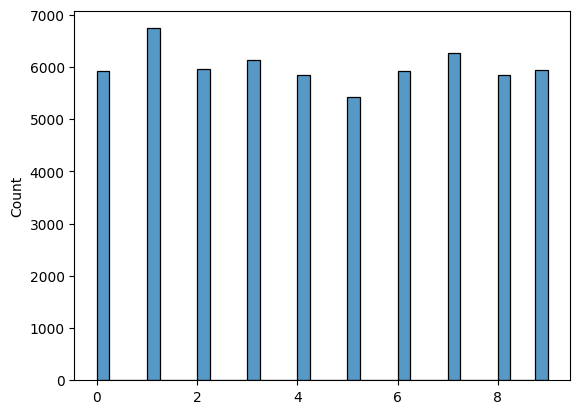

In [45]:
sns.histplot(data=y_train)

In [46]:
np.isnan(x_train).any()


False

In [47]:
np.isnan(x_test).any()


False

NORMALIZATION

In [48]:
input_shape = (28, 28, 1)
x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_train=x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_test=x_test/255.0

In [49]:
y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

In [50]:
x_test.shape

(10000, 28, 28, 1)

tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(10,), dtype=float32)


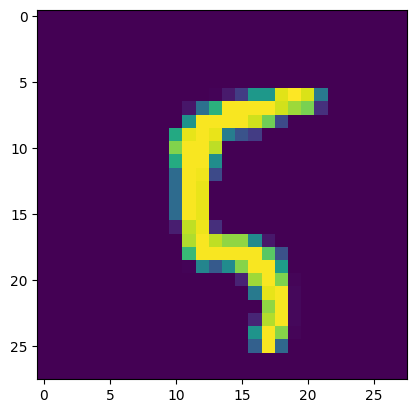

In [51]:
plt.imshow(x_train[100][:,:,0])
print(y_train[100])

CNN

In [52]:
batch_size = 64
num_classes = 10
epochs = 5

In [53]:
def build_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.Dense(
      hp.Choice('units', [8, 16, 32]),
      hp.Choice('activation', ['relu','sigmoid'])))
  model.add(keras.layers.Dense(1, activation='relu'))
  model.add(keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=input_shape))
  model.add(keras.layers.Conv2D(32, (5,5), padding='same', activation='relu'))
  model.add(keras.layers.MaxPool2D())
  model.add(keras.layers.Dropout(0.25))
  model.add(keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
  model.add(keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
  model.add(keras.layers.MaxPool2D(strides=(2,2)))
  model.add(keras.layers.Dropout(0.25))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(128, activation='relu'))
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(num_classes, activation='softmax'))
  model.compile(optimizer=tf.keras.optimizers.RMSprop(epsilon=1e-08), loss='categorical_crossentropy', metrics=['acc'])
  return model


In [54]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5)

In [55]:
tuner.search(x_train, y_train, epochs=5, validation_data=(x_test,y_test))
best_model = tuner.get_best_models()[0]

Trial 5 Complete [00h 01m 03s]
val_loss: 0.03274638205766678

Best val_loss So Far: 0.03274638205766678
Total elapsed time: 00h 06m 08s


In [56]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.995):
      print("\nReached 99.5% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [58]:
history = best_model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    callbacks=[callbacks])

Epoch 1/5
844/844 [==============================] - 12s 10ms/step - loss: 0.1015 - acc: 0.9755 - val_loss: 0.0286 - val_acc: 0.9925
Epoch 2/5
844/844 [==============================] - 8s 9ms/step - loss: 0.0992 - acc: 0.9765 - val_loss: 0.0419 - val_acc: 0.9905
Epoch 3/5
844/844 [==============================] - 8s 9ms/step - loss: 0.1006 - acc: 0.9760 - val_loss: 0.0476 - val_acc: 0.9892
Epoch 4/5
844/844 [==============================] - 7s 8ms/step - loss: 0.0979 - acc: 0.9774 - val_loss: 0.0341 - val_acc: 0.9918
Epoch 5/5
844/844 [==============================] - 8s 10ms/step - loss: 0.1015 - acc: 0.9769 - val_loss: 0.0543 - val_acc: 0.9880


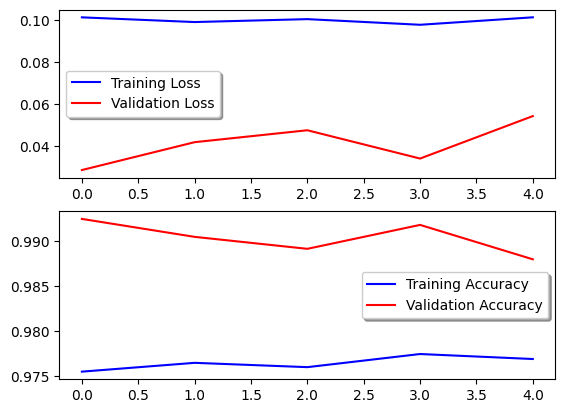

In [59]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [61]:
test_loss, test_acc = best_model.evaluate(x_test, y_test)


313/313 [==============================] - 2s 7ms/step - loss: 0.0457 - acc: 0.9898


In [62]:
# Predict the values from the testing dataset
Y_pred = best_model.predict(x_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert testing observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes)

313/313 [==============================] - 1s 3ms/step


<Axes: >

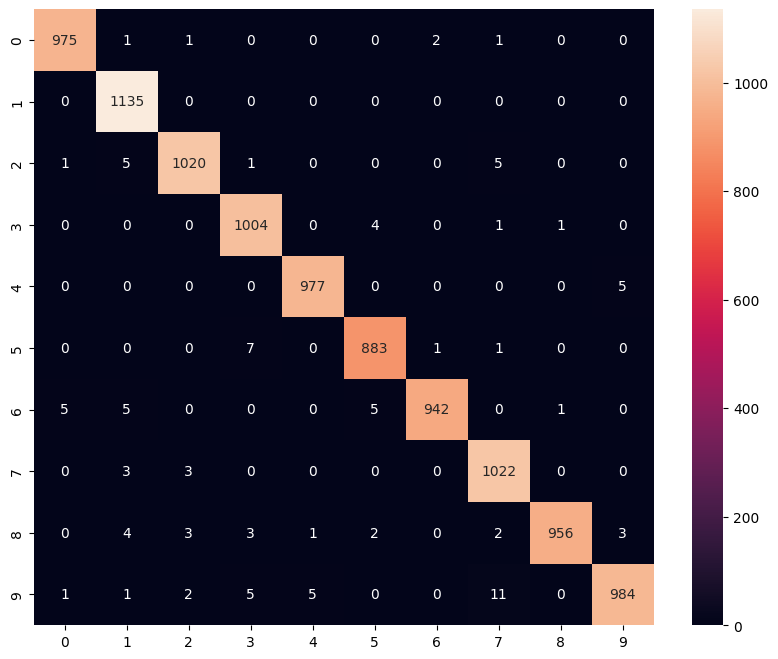

In [63]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')